In [224]:
import numpy as np
import pandas as pd

In [225]:
X = pd.read_csv("mimic-features.csv")
y = pd.read_csv("mimic-outcomes.csv")
T = pd.read_csv("mimic-treatments.csv")

In [226]:
np.random.seed(238)

hospital_ids = X["HADM_ID"].unique()
np.random.shuffle(hospital_ids)

val_cutoff = int(0.6*len(hospital_ids))
test_cutoff = int(0.8*len(hospital_ids))

id_train = hospital_ids[:val_cutoff]
id_val = hospital_ids[val_cutoff:test_cutoff]
id_test = hospital_ids[test_cutoff:]

X_train = X[X.isin(id_train).any(1)]
X_val = X[X.isin(id_val).any(1)]
X_test = X[X.isin(id_test).any(1)]

y_train = y[y.isin(id_train).any(1)]
y_val = y[y.isin(id_val).any(1)]
y_test = y[y.isin(id_test).any(1)]

treatment_train = T[T.isin(id_train).any(1)]
treatment_val = T[T.isin(id_val).any(1)]
treatment_test = T[T.isin(id_test).any(1)]

In [227]:
import causalml
from collections import namedtuple

DataTriple = namedtuple('DataTriple', ['X', 'treatment', 'y'])

In [228]:
X_train = X_train.to_numpy()[:, 1:]
y_train = y_train.to_numpy()[:, 1]
treatment_train = treatment_train.to_numpy()[:, 1]

X_val = X_val.to_numpy()[:, 1:]
y_val = y_val.to_numpy()[:, 1]
treatment_val = treatment_val.to_numpy()[:, 1]

X_test = X_test.to_numpy()[:, 1:]
y_test = y_test.to_numpy()[:, 1]
treatment_test = treatment_test.to_numpy()[:, 1]

In [229]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

from xgboost import XGBRegressor
import warnings

import lightgbm
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import SGDRegressor, SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPRegressor

In [230]:
import random
from collections import namedtuple
from itertools import combinations
from tqdm import tqdm, trange

import concurrent
import concurrent.futures

Observation = namedtuple('Observation', ['pred_benefit', 'outcome', 'treatment'])

import numpy as np
# from tqdm.auto import tqdm

def bool_to_polarity(a, b):
  if a > b: return -1
  elif b > a: return 1
  else: return 0
  # return 1 if b else -1

def mean(a, b):
  return (a + b) / 2

def c_statistic_bootstrap(pred_rr, y, w, num_iters=1000, alpha=0.05):
  pred_rr = np.array(pred_rr)
  y = np.array(y)
  w = np.array(w)
  c_stats = []
  for i in trange(num_iters):
    rows = np.random.randint(0, len(pred_rr), pred_rr.shape[0])
    c_stats.append(c_statistic(pred_rr[rows], y[rows], w[rows]))
  c_stats = sorted(c_stats)
  # print(int(len(c_stats) / 2))
  # print(int(len(c_stats) * alpha / 2))
  # print(c_stats[::100])
  med = c_stats[int(len(c_stats) / 2)]
  lb = c_stats[int(len(c_stats) * alpha / 2)]
  ub = c_stats[int(len(c_stats) * (1 - alpha / 2))]

  return med, lb, ub

def c_statistic_bootstrap_thread(pred_rr, y, w, num_iters=100, alpha=0.05):
  pred_rr = np.array(pred_rr)
  y = np.array(y)
  w = np.array(w)
  c_stats = []
  # for i in trange():
  #   rows = np.random.randint(0, len(pred_rr), pred_rr.shape[0])
  #   c_stats.append(c_statistic(pred_rr[rows], y[rows], w[rows]))
  # print(int(len(c_stats) / 2))
  # print(int(len(c_stats) * alpha / 2))
  # print(c_stats[::100])

  def func(_):
    rows = np.random.randint(0, len(pred_rr), pred_rr.shape[0])
    return c_statistic(pred_rr[rows], y[rows], w[rows])

  with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    c_stats = list(tqdm(executor.map(func, range(num_iters)), total=num_iters))


  c_stats = sorted(c_stats)

  med = c_stats[int(len(c_stats) / 2)]
  lb = c_stats[int(len(c_stats) * alpha / 2)]
  ub = c_stats[int(len(c_stats) * (1 - alpha / 2))]
  return med, lb, ub


def match_pairs(pred_rr, y, w):
  observations = [Observation(p_, y_, w_) for p_, y_, w_ in zip(pred_rr, y, w)]
  untreated = [obs for obs in observations if obs.treatment == 0]
  treated = [obs for obs in observations if obs.treatment == 1]
  # print(len(untreated), "untreated examples")
  # print(len(treated), "treated examples")
  # randomly subsample to ensure every person is matched

  min_size = min(len(untreated), len(treated))
  untreated = random.sample(untreated, min_size)
  treated = random.sample(treated, min_size)
  assert len(untreated) == len(treated)

  untreated = sorted(untreated, key=lambda obs: obs.pred_benefit)
  treated = sorted(treated, key=lambda obs: obs.pred_benefit)

  #obs_benefit_dict = {
  #    (0, 0): 0,
  #    (0, 1): -1,
  #    (1, 0): 1,
  #    (1, 1): 0,
  #}
  # calculate observed and predicted benefit for each pair
  pairs = list(zip(untreated, treated))
  return pairs

def c_statistic(pred_rr, y, w):
    """
    Return concordance-for-benefit, the proportion of all matched pairs with
    unequal observed benefit, in which the patient pair receiving greater
    treatment benefit was predicted to do so.
    pred_rr := predicted treatment benefit
    y       := outcome
    w       := treatment
    """
    # ensure results are reproducible
    random.seed(229)
    assert len(pred_rr) == len(w) == len(y)

    # match all pairs on predicted benefit
    pairs = match_pairs(pred_rr, y, w)
    #obs_benefit = [obs_benefit_dict[(u[1], t[1])] for (u, t) in pairs]
    obs_benefit = [bool_to_polarity(u.outcome, t.outcome) for (u, t) in pairs]
    pred_benefit = [mean(u.pred_benefit, t.pred_benefit) for (u, t) in pairs]
    # for (u, t) in pairs[:5]:
    #   print(u, t)
    # print()
    # for (u, t) in pairs[-5:]:
    #   print(u, t)

    # iterate through all (N choose 2) pairs
    outcome_ties = 0
    risk_ties = 0
    good_outcomes = 0
    total = 0
    for ((o1, p1), (o2, p2)) in combinations(zip(obs_benefit, pred_benefit), r=2):
      # print(o1, p1, o2, p2)
      if o1 == o2:
        outcome_ties += 1
        continue
      if p1 == p2:
        risk_ties += 1
        continue
      if ((o1 > o2) and (p1 > p2)) or ((o1 < o2) and (p1 < p2)):
        good_outcomes += 1
      total += 1
    # print(outcome_ties, "outcome ties;", end=" ")
    # print(risk_ties, "risk ties;", end=" ")
    # print(good_outcomes, "good outcomes;", end=" ")
    # print(total, "total outcomes", end=" ")
    # print()
    if total == 0: return -1
    return good_outcomes / total


In [231]:
def bootstrap(X, y, treatment, runs=5000):

    cate = model.predict(X) * -1
    answers = []
    for i in range(runs):
        indexes = np.random.permutation(range(len(X)))[0:len(X)//2]
        answers.append(c_statistic(cate[indexes], y[indexes] * -1, treatment[indexes]))
    answers = sorted(answers)
    print("95% CI:", answers[runs//2], "(", answers[int(0.025*runs)], answers[int(0.975*runs)],")")

# Train Model 

adjust hyperparameters in this cell to optimize Validation Score (0.6 and above is ideal)

In [232]:
# TRAIN MODEL: 

#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
model = BaseXRegressor(learner=XGBRegressor(random_state=238))
cate = model.fit_predict(X=X_train, treatment=treatment_train, y=y_train)

In [233]:
# print("Validation C-for-benefit")
# bootstrap(X_val, y_val, treatment_val)
print("Test C-for-benefit")
bootstrap(X_test, y_test, treatment_test)

Test C-for-benefit
95% CI: 0.5277883276364097 ( 0.43618090452261304 0.6172370088719898 )


In [234]:
cate *= -1 # this coordinates things to make sure that we are actually SAVING time from being in the hospital. A positive score

In [235]:
cate = model.predict(X_test) * -1

treatment_improvement = []
keep_improvement = []

for i in range(len(cate)):
    
    if cate[i] > 0 and treatment_test[i] == 0: # benefit from letting them leave
        treatment_improvement.append(cate[i][0])
    elif cate[i] < 0 and treatment_test[i] == 1: # benefit from letting them stay
        keep_improvement.append(cate[i][0])

print("total time steps analyzed:", len(cate))
print("total times agreed:", len(cate) - len(treatment_improvement) - len(keep_improvement))
print("Agreement Percentage:", 100*(len(cate) - len(treatment_improvement) - len(keep_improvement))/len(cate),"%")
print("Physicians kept in ER, but should release:", len(treatment_improvement))
print("Physicians released from ER, but should keep:", len(keep_improvement))

treatment_improvement = sorted(treatment_improvement)
keep_improvement = sorted(keep_improvement)
print("Average Improvement of Releasing (box plot):", treatment_improvement[len(treatment_improvement)//4], treatment_improvement[len(treatment_improvement)//2], treatment_improvement[3*len(treatment_improvement)//4])
print("Average Improvement of Keeping (box plot):", keep_improvement[len(keep_improvement)//4], keep_improvement[len(keep_improvement)//2], keep_improvement[3*len(keep_improvement)//4])
# print(treatment_improvement)
# print(keep_improvement)
AOI = (treatment_improvement[len(treatment_improvement)//2]*len(treatment_improvement) - keep_improvement[len(keep_improvement)//2]*len(keep_improvement))/(len(treatment_improvement) + len(keep_improvement))
print("Average Outcome Improvement:", AOI)

total time steps analyzed: 8018
total times agreed: 4373
Agreement Percentage: 54.53978548266401 %
Physicians kept in ER, but should release: 3448
Physicians released from ER, but should keep: 197
Average Improvement of Releasing (box plot): 0.010084862229238429 0.020439328391335585 0.0404716707083787
Average Improvement of Keeping (box plot): -0.05929628239299433 -0.02744222073014866 -0.013636249283384253
Average Outcome Improvement: 0.02081781118715072


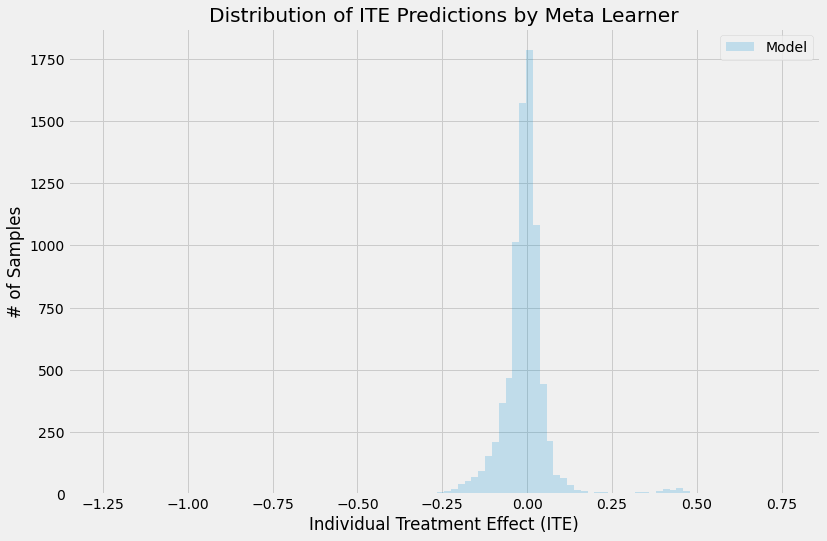

In [236]:
from matplotlib import pyplot as plt

alpha=0.2
bins=100
plt.figure(figsize=(12,8))
plt.hist(cate, alpha=alpha, bins=bins, label='Model')
plt.title('Distribution of ITE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE)')
plt.ylabel('# of Samples')
_=plt.legend()



In [237]:
import shap
shap.initjs()

In [153]:
def f(x):
    return model.predict(x) * -1
 
explainer = shap.KernelExplainer(f, shap.kmeans(X_val, 100))

In [154]:
shap_values = explainer.shap_values(X_val, nsamples=10) #nsamples=100

In [281]:
cols = list(X.columns[1:])

for i in range(len(cols)):
    cols[i] = cols[i].replace("50868", "ANION_GAP")
    cols[i] = cols[i].replace("50882", "BICARBONATE")
    cols[i] = cols[i].replace("50893", "CALCIUM")
    cols[i] = cols[i].replace("50931", "GLUCOSE")
    cols[i] = cols[i].replace("50912", "CREATININE")
    cols[i] = cols[i].replace("50902", "CHLORIDE")
    cols[i] = cols[i].replace("50960", "MAGNESIUM")
    cols[i] = cols[i].replace("51237", "INR(PT)")
    cols[i] = cols[i].replace("51221", "HEMATOCRIT")
    cols[i] = cols[i].replace("50970", "PHOSPHATE")
    cols[i] = cols[i].replace("51006", "UREA NITROGEN")
    cols[i] = cols[i].replace("51301", "WHITE BLOOD CELLS")
    

print(cols)
# 1. TimeBlocks
# 2. 20868 —> Anion Gap
# 3. 50882 —> Bicarbonate
# 4. 50893 —> Calcium
# 5. 50931 —> Glucose
# 6. 50912 —> Creatinine
# 7. 50902 —> Chloride
# 8. 50960 —> Magnesium
# 9. 51237 —> INR(PT)
# 10. 51221  —> Hermatocrit 
# 11. 50970 —> Phosphate
# 12. 51006 —> Urea Nitrogen
# 13. 51301 —> White Blood Cells

['TIME_BLOCKS_SINCE_ADMITTED', 'ANION_GAP_VALUENUM', 'ANION_GAP_ABNORMAL_FLAG', 'BICARBONATE_VALUENUM', 'BICARBONATE_ABNORMAL_FLAG', 'CALCIUM_VALUENUM', 'CALCIUM_ABNORMAL_FLAG', 'CHLORIDE_VALUENUM', 'CHLORIDE_ABNORMAL_FLAG', 'CREATININE_VALUENUM', 'CREATININE_ABNORMAL_FLAG', 'GLUCOSE_VALUENUM', 'GLUCOSE_ABNORMAL_FLAG', 'MAGNESIUM_VALUENUM', 'MAGNESIUM_ABNORMAL_FLAG', 'PHOSPHATE_VALUENUM', 'PHOSPHATE_ABNORMAL_FLAG', '50971_VALUENUM', '50971_ABNORMAL_FLAG', '50983_VALUENUM', '50983_ABNORMAL_FLAG', 'UREA NITROGEN_VALUENUM', 'UREA NITROGEN_ABNORMAL_FLAG', 'HEMATOCRIT_VALUENUM', 'HEMATOCRIT_ABNORMAL_FLAG', '51222_VALUENUM', '51222_ABNORMAL_FLAG', 'INR(PT)_VALUENUM', 'INR(PT)_ABNORMAL_FLAG', '51248_VALUENUM', '51248_ABNORMAL_FLAG', '51249_VALUENUM', '51249_ABNORMAL_FLAG', '51250_VALUENUM', '51250_ABNORMAL_FLAG', '51265_VALUENUM', '51265_ABNORMAL_FLAG', '51274_VALUENUM', '51274_ABNORMAL_FLAG', '51275_VALUENUM', '51275_ABNORMAL_FLAG', '51277_VALUENUM', '51277_ABNORMAL_FLAG', '51279_VALUENUM', 

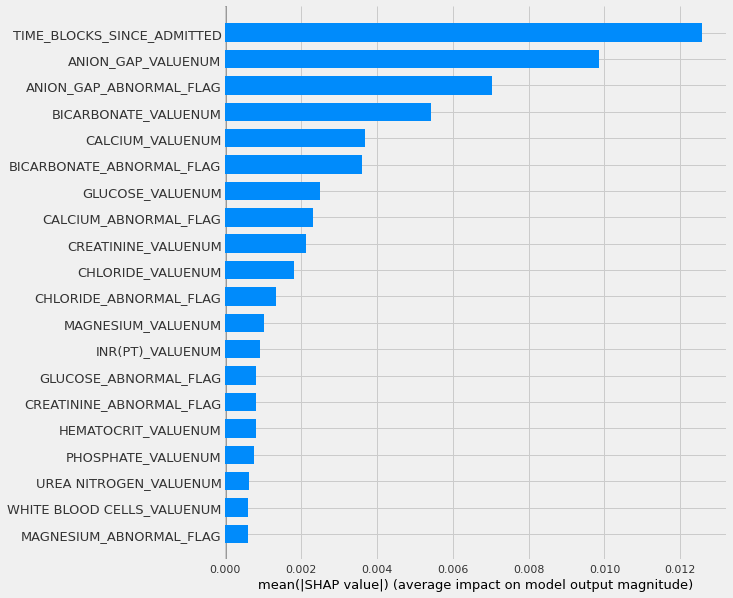

In [282]:
shap.summary_plot(shap_values[0], X_val, plot_type="bar", feature_names=cols)

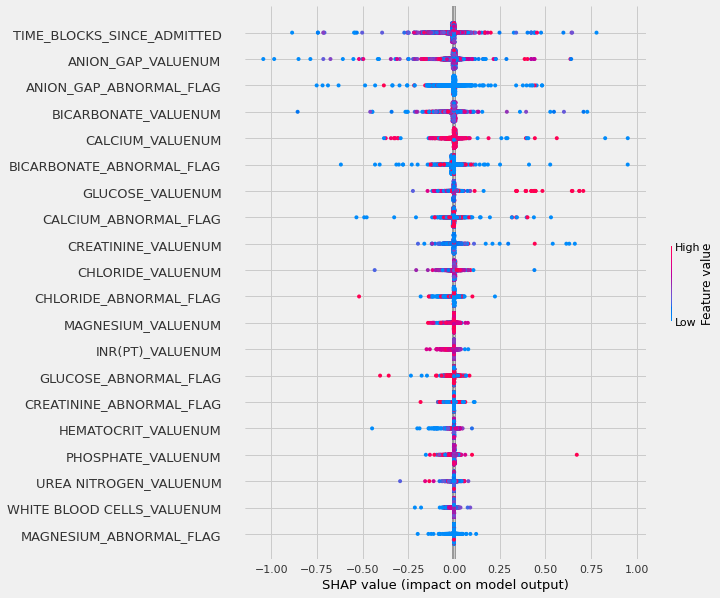

In [284]:
shap.summary_plot(shap_values[0], X_val, plot_type="dot", feature_names=cols)